In [1]:
from sstadex import Macromodel, Primitive, dfs, simplediffpair, cs_pmos, cm_pmos, spice_sim
import numpy as np
from sympy import Symbol
from sympy.solvers import solve
import matplotlib.pyplot as plt
import paretoset as pareto
import pandas as pd
from sympy import lambdify

XSCHEM_RCFILE = "/opt/pdks/sky130A/libs.tech/xschem/xschemrc"
SPICE_DIR = "./spice/"
OUTPUT_DIR = "./output/"
XSCHEM_DIR = "./xschem/"

In [2]:
## Exploration parameters

N_points = 10
lengths = [0.4e-06, 0.8e-06, 1.6e-06, 3.2e-06, 6.4e-6]

## Electrical parameters

Vout = 1.2                                     # LDO output voltage
Vin = 1.8                                      # LDO supply voltage
Vref = 0.9                                     # LDO voltage reference
IL = 100e-3                                      # Load current
CL = 50e-12                                        # Load capacitance
RL = Vout/IL

## LDO specifications
    
psrr_condition = -60
estability_condition = 80
linereg_condition = 0.5
loadreg_condition = 0.7
iq_condition = 20e-6
size_condition = 1e-3

# Macromodels and primitives definitions

### LDO

In [122]:
## Electrical variables

Vg = np.linspace(Vin - (Vin - Vout), 1.8, 5)

LDO_macro = Macromodel(name = "ldo",
                       electrical_parameters = {"Vdd": Vin, 
                                                "Vref": Vref, 
                                                "Vout": Vout, 
                                                "Vaout": 1.05,
                                                "Il": IL} 
                       )

### Two Stage OTA

In [123]:
## Electrical variables

Vg_ota = np.linspace(LDO_macro.electrical_parameters["Vdd"] - (LDO_macro.electrical_parameters["Vdd"] - LDO_macro.electrical_parameters["Vaout"]), LDO_macro.electrical_parameters["Vdd"], 5)

stage2_OTA_macro = Macromodel(name = "stage2_OTA",
                              macromodel_parameters={Symbol('Ra'): np.logspace(3, 7, N_points),
                                                     Symbol('gma'): np.logspace(-5, -2, N_points),
                                                     Symbol('Ca'): np.logspace(-17, -12, N_points)},
                              electrical_parameters = {"Vdd": LDO_macro.electrical_parameters["Vdd"], 
                                                       "Vneg": LDO_macro.electrical_parameters["Vref"], 
                                                       "Vpos": LDO_macro.electrical_parameters["Vref"], 
                                                       "Vout": LDO_macro.electrical_parameters["Vaout"],
                                                       "Vaouts1": 0.95}
                              )

### First Stage OTA

In [124]:
OTA_macro = Macromodel(name = "ota_cap",
                       req_tfs = [["vout", "vpos"], ["vout", "vpos"]],
                       macromodel_parameters={Symbol('Ra_1stage'): np.logspace(3, 7, N_points),
                                              Symbol('gma_1stage'): np.logspace(-5, -2, N_points),
                                              Symbol('Ca_1stage'): np.logspace(-17, -12, N_points)},
                       electrical_parameters={Symbol("gdif_2"): Symbol("gdif_1"),
                                              Symbol("Rdif_2"): Symbol("Rdif_1")}
                      )

# Primitives

In [125]:
pt = cs_pmos(netlist='pmos_cm.spice', 
             type='pmos', 
             inputs={'vds_lut': LDO_macro.electrical_parameters["Vout"]-LDO_macro.electrical_parameters["Vdd"], 
                     'vgs_lut': (-1.8, -0.1, 0.01), 
                     'vgs': LDO_macro.electrical_parameters["Vaout"]-LDO_macro.electrical_parameters["Vdd"], 
                     'il': LDO_macro.electrical_parameters["Il"],
                     'length': lengths, 
                     '2d_var': ['length', 'vgs']})

pt.build()

pt.parameters = {Symbol('gm_pt'): np.asarray(pt.gm).flatten(),
                 Symbol('Ro_pt'): np.asarray(pt.Ro/(IL/20e-6)).flatten()}

length
vgs
0


In [126]:
stage2_t = cs_pmos(netlist='pmos_cm.spice', 
                   type='pmos', 
                   inputs={'vds_lut': stage2_OTA_macro.electrical_parameters["Vout"]-stage2_OTA_macro.electrical_parameters["Vdd"], 
                           'vgs_lut': (-1.8, -0.1, 0.01), 
                           'vgs': stage2_OTA_macro.electrical_parameters["Vaouts1"]-stage2_OTA_macro.electrical_parameters["Vdd"], 
                           'il': 20e-6,
                           'length': lengths, 
                           '2d_var': ['length', 'vgs']})

stage2_t.build()

stage2_t.parameters = {Symbol('gm_stage2'): np.asarray(stage2_t.gm).flatten(),
                 Symbol('Ro_stage2'): np.asarray(stage2_t.Ro).flatten()}

length
vgs
0


In [127]:
# Diffpair primitive definition

vs = np.linspace(0.1, 0.8, 20)
vds_diffpar = stage2_OTA_macro.electrical_parameters["Vaouts1"] - vs
vgs_diffpar = stage2_OTA_macro.electrical_parameters["Vpos"] - vs

diffpair_primitive = simplediffpair(netlist='simplediffpair.spice', type='nmos', inputs={'vds_lut': (0.1, 1.2, 0.01), 'vgs_lut': (0.1, 1.8, 0.01), 'vds': vds_diffpar, 'vgs': vgs_diffpar, 'il': 20e-6,
                  'length': lengths, '2d_var': ['vds', 'vgs']})

diffpair_primitive.build()

diffpair_primitive.parameters = {Symbol("Rdif_1"): np.asarray(diffpair_primitive.Ro).flatten(), 
                                 Symbol("gdif_1"): np.asarray(diffpair_primitive.gm).flatten(),
                                 Symbol("Cgd"): np.asarray(diffpair_primitive.cgd).flatten(),
                                 Symbol("Cgs"): np.asarray(diffpair_primitive.cgs).flatten()}

vds
vgs
1


In [128]:
ota_cm_pmos = cm_pmos(name='ota_cm_pmos', 
                      netlist='pmos_cm.spice', 
                      type='pmos', 
                      inputs={'vds_lut': stage2_OTA_macro.electrical_parameters["Vaouts1"]-stage2_OTA_macro.electrical_parameters["Vdd"], 
                              'vgs_lut': (-1.8, -0.1, 0.01), 
                              'vgs': stage2_OTA_macro.electrical_parameters["Vaouts1"]-stage2_OTA_macro.electrical_parameters["Vdd"], 
                              'il': 20e-6,
                              'length': lengths, 
                              '2d_var': ['length', 'vgs']})
ota_cm_pmos.build()

ota_cm_pmos.parameters = {Symbol("Raload_1"): np.asarray(ota_cm_pmos.Ro).flatten(),
                          Symbol("Raload_2"): 1/np.asarray(ota_cm_pmos.gm).flatten(),
                          Symbol("gaload"): np.asarray(ota_cm_pmos.gm).flatten()}

length
vgs
0


# Exploration

In [129]:
class test:
    def __init__(self) -> None:
        pass
    def eval(funct):
        return {"eval": funct}

## LDO

In [130]:
LDO_macro.primitives = [pt]
LDO_macro.submacromodels = [stage2_OTA_macro]

#################### PSRR #######################
psrr = test()
psrr.tf = ["vout", "vdd"]
psrr.parametros = {Symbol("V1"): 1,
                   Symbol("V2"): 0,
                   Symbol("s"): 0,
                   Symbol("Rl"): RL,
                   Symbol("Cl"): CL,
                   Symbol("Cc"): 1e-12,
                   Symbol("R1"): 100000,
                   Symbol("R2"): 300000}

psrr.conditions = {"max": [-70]}
psrr.variables = {}
psrr.out_def = {"eval": psrr.tf}

#################### gbw #######################
gbw = test()
gbw.tf = ["vout", "vdd"]
gbw.parametros = {Symbol("V1"): 1,
                  Symbol("V2"): 0,
                  Symbol("Rl"): RL,
                  Symbol("Cl"): CL,
                   Symbol("Cc"): 1e-12,
                  Symbol("R1"): 100000,
                  Symbol("R2"): 300000}
gbw.conditions = {"min": [1e4]}
gbw.variables = {}
gbw.out_def = {"eval": gbw.tf}

#################### load regulation #######################
loadreg = test()
loadreg.tf = ["vout", "vdd"]
loadreg.parametros = {Symbol("V1"): 1.8,
                      Symbol("V2"): 0.9,
                      Symbol("s"): 0,
                      Symbol("Cl"): CL,
                      Symbol("Cc"): 1e-12,
                      Symbol("R1"): 100000,
                      Symbol("R2"): 300000}
loadreg.variables = {Symbol('Rl'): [RL, RL+1200]}
loadreg.out_def = {'diff': [loadreg.tf, loadreg.variables]}
loadreg.conditions = {'max': [1]}

LDO_macro.specifications = [psrr, gbw, loadreg]

results, axes, primoutputs = dfs(LDO_macro, levels = 1)

Macro results of:  ldo
Running MNA... 
   vdd  vout  net1  vfb  vss  net2
0    1     2     3    4    0     5



   X server connection failed, although DISPLAY shell variable is set.
   A possible reason is that the X server is not running or DISPLAY shell variable
   is incorrectly set.
   Starting Xschem in text only mode.



[['vout', 'vdd'], ['vout', 'vdd'], ['vout', 'vdd']]
A:  Matrix([[Ca*s + gm_pt + 1/Ro_pt + 1/Ra, -1/Ro_pt, -Ca*s - gm_pt - 1/Ra, gma, -gma, 1, 0], [-gm_pt - 1/Ro_pt, Cc*s + Cl*s + 1/Ro_pt + 1/Rl + 1/R1, -Cc*s + gm_pt, -1/R1, 0, 0, 0], [-Ca*s - 1/Ra, -Cc*s, Ca*s + Cc*s + 1/Ra, -gma, gma, 0, 0], [0, -1/R1, 0, 1/R2 + 1/R1, 0, 0, 0], [0, 0, 0, 0, 0, 0, 1], [1, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 1, 0, 0]])
[v1, v2, v3, v4, v5, I_V1, I_V2]
{I_V1: (-Ca*Cc*Cl*R1*Ra*Rl*Ro_pt*V1*s**3 - Ca*Cc*Cl*R2*Ra*Rl*Ro_pt*V1*s**3 - Ca*Cc*R1*Ra*Ro_pt*V1*s**2 - Ca*Cc*R2*Ra*Ro_pt*V1*s**2 - Ca*Cc*Ra*Rl*Ro_pt*V1*s**2 - Ca*Cl*R1*Ra*Rl*V1*s**2 - Ca*Cl*R2*Ra*Rl*V1*s**2 - Ca*R1*Ra*V1*s - Ca*R2*Ra*V1*s - Ca*Ra*Rl*V1*s - Cc*Cl*R1*Ra*Rl*Ro_pt*V1*gm_pt*s**2 + Cc*Cl*R1*Ra*Rl*Ro_pt*V2*gma*s**2 - Cc*Cl*R1*Ra*Rl*V1*s**2 - Cc*Cl*R1*Rl*Ro_pt*V1*s**2 - Cc*Cl*R2*Ra*Rl*Ro_pt*V1*gm_pt*s**2 + Cc*Cl*R2*Ra*Rl*Ro_pt*V2*gma*s**2 - Cc*Cl*R2*Ra*Rl*V1*s**2 - Cc*Cl*R2*Rl*Ro_pt*V1*s**2 - Cc*R1*Ra*Ro_pt*V1*gm_pt*s + Cc*R1*Ra*Ro_pt*V2*gma*s - Cc*

### PSRR

In [131]:
results[0].shape

(1000, 5)

In [132]:
num_of_point_macro = 1000

In [133]:
pt.L = np.asarray(lengths)

In [134]:
W_pt = np.tile(pt.W.flatten(), num_of_point_macro)
L_pt = np.tile(pt.L.flatten(), num_of_point_macro)
WL_pt =W_pt+L_pt

psrr_ldo = 20*np.log10(np.abs(results[0]))

In [135]:
psrr_ldo_mask = np.full(psrr_ldo.flatten().shape, True)
for idx, gain in enumerate(psrr_ldo.flatten()):
    for cond in psrr.conditions["max"]:
        if gain<cond:
            psrr_ldo_mask[idx] = True
        else:
            psrr_ldo_mask[idx] = False

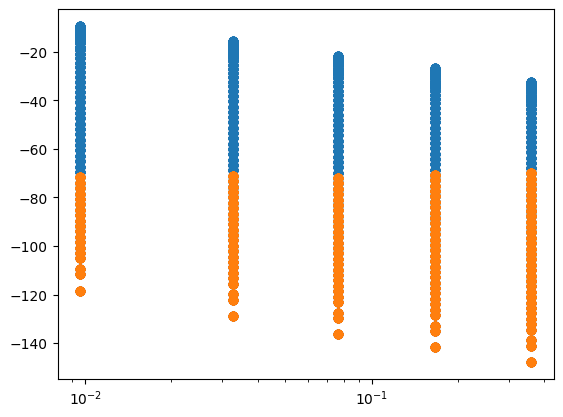

In [136]:
plt.scatter(WL_pt, psrr_ldo.flatten())
plt.scatter(WL_pt[psrr_ldo_mask], psrr_ldo.flatten()[psrr_ldo_mask])
plt.xscale("log")

In [137]:
gma = np.repeat([i[1] for i in axes], 5)
Ra = np.repeat([i[0] for i in axes], 5)
Ca = np.repeat([i[2] for i in axes], 5)

gm_pt = np.asarray([i[3] for i in axes]).flatten()
Ro_pt = np.asarray([i[4] for i in axes]).flatten()

In [138]:

df = pd.DataFrame({
    "gain": 20*np.log10(gma[psrr_ldo_mask]*Ra[psrr_ldo_mask]),
})

df.sort_values(by="gain")

,gain
0,22.222222
1,22.222222
442,22.222222
443,22.222222
440,22.222222
...,...
2205,100.000000
2204,100.000000
2203,100.000000
2202,100.000000


### gbw

In [139]:
frec = Symbol("frec")

gbw_j = []

for i in results[1].flatten():
    temp = i.subs({Symbol("s"): frec*2j*np.pi})
    gbw_j.append(temp)

In [140]:
f = np.logspace(1, 9, 200)
gbw_final = []
phase_final = []

for i in gbw_j:
    gbw_lamb = lambdify(frec, i)
    raw = gbw_lamb(f)
    abs_values = np.abs(20*np.log10(np.abs(raw)))
    abs_values = abs_values-(abs_values[0]-3)
    cross = np.argmin(np.abs(abs_values))
    gbw_final.append(f[cross])
    phase_final.append(np.angle(raw[cross])*180/(np.pi))

gbw_final = np.asarray(gbw_final)

In [141]:
gbw_ldo_mask = np.full(gbw_final.shape, True)
for idx, gain in enumerate(gbw_final.flatten()):
    for cond in gbw.conditions["min"]:
        if gain>cond:
            gbw_ldo_mask[idx] = True
        else:
            gbw_ldo_mask[idx] = False

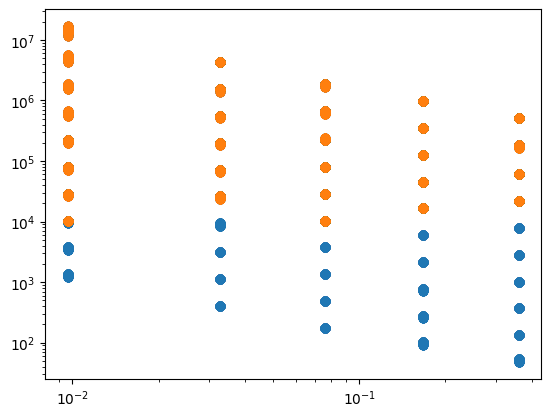

In [142]:
plt.scatter(WL_pt, gbw_final)
plt.scatter(WL_pt[gbw_ldo_mask], np.asarray(gbw_final)[gbw_ldo_mask])
plt.xscale("log")
plt.yscale("log")

In [143]:
gma = np.repeat([i[1] for i in axes], 5)
Ra = np.repeat([i[0] for i in axes], 5)
Ca = np.repeat([i[2] for i in axes], 5)

gm_pt = np.asarray([i[3] for i in axes]).flatten()
Ro_pt = np.asarray([i[4] for i in axes]).flatten()

In [144]:
print(gma[300])
print(Ra[300])
print(Ca[300])

print(gm_pt[300])
print(Ro_pt[300])

9.999999999999999e-06
464158.8833612772
9.999999999999999e-18
0.5039956812416986
22.019452838603893


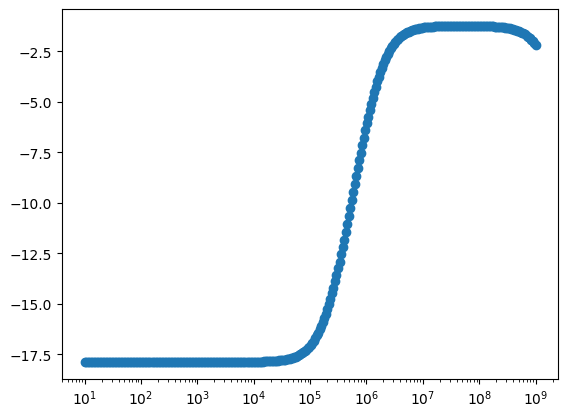

In [145]:
gbw_lamb = lambdify(frec, gbw_j[200])
f = np.logspace(1, 9, 300)
abs_values = 20*np.log10(np.abs(gbw_lamb(f)))

plt.scatter(f, abs_values)
plt.xscale("log")

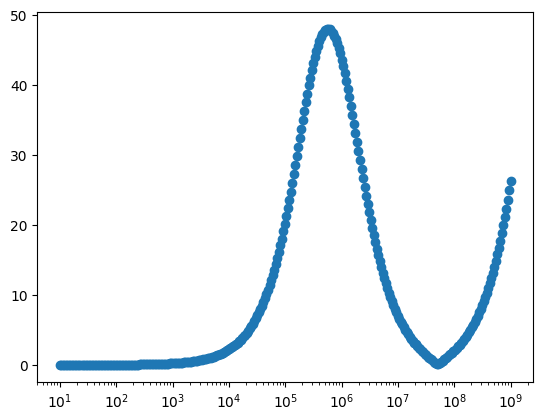

In [146]:
phase_values = np.angle(gbw_lamb(f))

plt.scatter(f, np.abs((phase_values*180)/np.pi))
plt.xscale("log")

### load regulation

In [147]:
loadreg_ldo = np.abs(results[2][0].flatten())*100

loadreg_ldo_mask = np.full(loadreg_ldo.shape, True)
for idx, gain in enumerate(loadreg_ldo.flatten()):
    for cond in loadreg.conditions["max"]:
        if gain<cond:
            loadreg_ldo_mask[idx] = True
        else:
            loadreg_ldo_mask[idx] = False

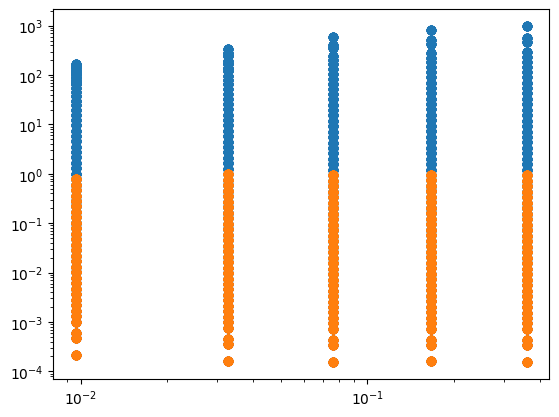

In [148]:
plt.scatter(WL_pt, loadreg_ldo)
plt.scatter(WL_pt[loadreg_ldo_mask], loadreg_ldo[loadreg_ldo_mask])
plt.yscale("log")
plt.xscale("log")

### W max

In [149]:
W_pt_mask = np.full(W_pt.shape, True)
for idx, gain in enumerate(W_pt):
    for cond in [10e-3]:
        if gain<cond:
            W_pt_mask[idx] = True
        else:
            W_pt_mask[idx] = False

### Resume

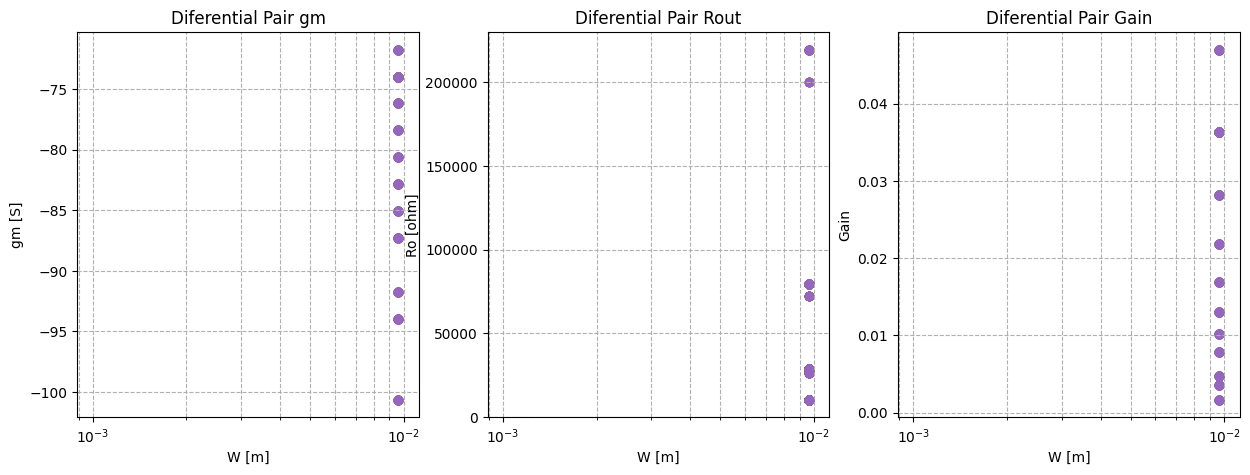

In [150]:
ldo_macro_mask = psrr_ldo_mask & gbw_ldo_mask & loadreg_ldo_mask & W_pt_mask

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for index, val in enumerate(lengths):
    axs[0].scatter(WL_pt[ldo_macro_mask], psrr_ldo.flatten()[ldo_macro_mask])

axs[0].set_title('Diferential Pair gm')
axs[0].set_xlabel('W [m]')
axs[0].set_ylabel('gm [S]')

for index, val in enumerate(lengths):
    axs[1].scatter(WL_pt[ldo_macro_mask], gbw_final[ldo_macro_mask])

axs[1].set_title('Diferential Pair Rout')
axs[1].set_xlabel('W [m]')
axs[1].set_ylabel('Ro [ohm]')


for index, val in enumerate(lengths):
    axs[2].scatter(WL_pt[ldo_macro_mask], loadreg_ldo[ldo_macro_mask])

axs[2].set_title('Diferential Pair Gain')
axs[2].set_xlabel('W [m]')
axs[2].set_ylabel('Gain')

axs[0].set_xscale('log')
axs[1].set_xscale('log')
axs[2].set_xscale('log')

axs[0].grid(linestyle = "dashed", which="both")
axs[1].grid(linestyle = "dashed", which="both")
axs[2].grid(linestyle = "dashed", which="both")

In [151]:
gma = np.repeat([i[1] for i in axes], 5)
Ra = np.repeat([i[0] for i in axes], 5)
Ca = np.repeat([i[2] for i in axes], 5)

gm_pt = np.asarray([i[3] for i in axes]).flatten()
Ro_pt = np.asarray([i[4] for i in axes]).flatten()

In [152]:
index = 0
print(gm_pt[ldo_macro_mask][index])
print(Ro_pt[ldo_macro_mask][index])
print(gma[ldo_macro_mask][index])
print(Ra[ldo_macro_mask][index])   
print(Ca[ldo_macro_mask][index])

print(psrr_ldo.flatten()[ldo_macro_mask][index])

0.5039956812416986
22.019452838603893
0.00046415888336127773
1291549.6650148826
9.999999999999999e-18
-73.96638128662131


In [153]:
df = pd.DataFrame({
    "gma": gma[ldo_macro_mask],
    "Ra": Ra[ldo_macro_mask],
    "Ca": Ca[ldo_macro_mask],
    "gain": 20*np.log10(gma[ldo_macro_mask]*Ra[ldo_macro_mask]),
})

df.sort_values(by=["gain"])

,gma,Ra,Ca,gain
12,0.001,4.641589e+05,4.641589e-16,53.333333
15,0.001,4.641589e+05,2.154435e-14,53.333333
13,0.001,4.641589e+05,1.668101e-15,53.333333
14,0.001,4.641589e+05,5.994843e-15,53.333333
10,0.001,4.641589e+05,3.593814e-17,53.333333
...,...,...,...,...
110,0.010,1.291550e+06,1.668101e-15,82.222222
111,0.010,1.291550e+06,5.994843e-15,82.222222
112,0.010,1.291550e+06,2.154435e-14,82.222222
113,0.010,1.291550e+06,7.742637e-14,82.222222


In [154]:
gma_min = 0.001
Ra_min = 4.641589e+05
Ca_min = 1e-17

20*np.log10(gma_min*Ra_min)

np.float64(53.333333644696765)

## Two stage OTA

In [155]:
stage2_OTA_macro.primitives = [stage2_t]
stage2_OTA_macro.submacromodels = [OTA_macro]

#################### PSRR #######################
psrr = test()
psrr.tf = ["vout", "V_p"]
psrr.parametros = {Symbol("V1"): 0,
                   Symbol("V2"): 1,
                   Symbol("V3"): 0,
                   Symbol("Il"): 0, 
                   Symbol("I2"): 0,
                   Symbol("Cl"): 0,
                   Symbol("s"): 0}
psrr.variables = {}
psrr.out_def = {"eval": psrr.tf}
 
#################### PSRR #######################
gbw = test()
gbw.tf = ["vout", "V_p"]
gbw.parametros = { Symbol("V1"): 0,
                   Symbol("V2"): 1,
                   Symbol("V3"): 0,
                   Symbol("Il"): 0,
                   Symbol("I2"): 0,
                   Symbol("Cl"): 1e-12}
gbw.variables = {}
gbw.out_def = {"eval": gbw.tf}

stage2_OTA_macro.specifications = [psrr, gbw]
results_2, axes_2, primoutputs_2 = dfs(stage2_OTA_macro, levels=1)

Macro results of:  stage2_OTA
Running MNA... 
   net1  vout  Vaout  vss  V_p  V_n
0     1     2      3    0    4    5



   X server connection failed, although DISPLAY shell variable is set.
   A possible reason is that the X server is not running or DISPLAY shell variable
   is incorrectly set.
   Starting Xschem in text only mode.



[['vout', 'V_p'], ['vout', 'V_p']]
A:  Matrix([[gm_stage2 + 1/Ro_stage2, -1/Ro_stage2, -gm_stage2, 0, 0, 1, 0, 0], [-gm_stage2 - 1/Ro_stage2, C2*s + Cl*s + 1/Ro_stage2, -C2*s + gm_stage2, 0, 0, 0, 0, 0], [0, -C2*s, C2*s + Ca_1stage*s + 1/Ra_1stage, -gma_1stage, gma_1stage, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 1], [0, 0, 0, 0, 0, 0, 1, 0], [1, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 1, 0, 0, 0], [0, 0, 0, 1, 0, 0, 0, 0]])
[v1, v2, v3, v4, v5, I_V1, I_V3, I_V2]
{I_V1: (-C2*Ca_1stage*Ra_1stage*Ro_stage2*V1*gm_stage2*s**2 - C2*Ca_1stage*Ra_1stage*V1*s**2 - C2*Cl*Ra_1stage*Ro_stage2*V1*gm_stage2*s**2 - C2*Cl*Ra_1stage*V1*s**2 - C2*I2*Ra_1stage*Ro_stage2*gm_stage2*s - C2*I2*Ra_1stage*s + C2*Ra_1stage*Ro_stage2*V2*gm_stage2*gma_1stage*s - C2*Ra_1stage*Ro_stage2*V3*gm_stage2*gma_1stage*s + C2*Ra_1stage*V2*gma_1stage*s - C2*Ra_1stage*V3*gma_1stage*s - C2*Ro_stage2*V1*gm_stage2*s - C2*V1*s - Ca_1stage*Cl*Ra_1stage*Ro_stage2*V1*gm_stage2*s**2 - Ca_1stage*Cl*Ra_1stage*V1*s**2 - Ca_1stage*I2*Ra_1stage*s + Cl

In [156]:
stage2_OTA_macro.name = "stage2_OTA_r"

stage2_OTA_macro.primitives = [stage2_t]
stage2_OTA_macro.submacromodels = [OTA_macro]

#################### rout #######################
rout = test()
rout.tf = ["vout", "vr"]
rout.parametros = {Symbol("V1"): 0,
                   Symbol("V2"): 0,
                   Symbol("V3"): 0,
                   Symbol("V4"): 1,
                   Symbol("Ra_1"): 1000,
                   Symbol("I2"): 0,
                   Symbol("Cl"): 0,
                   Symbol("s"): 0}
rout.variables = {}
rout.out_def = {"eval": rout.tf}

stage2_OTA_macro.specifications = [rout]

results_3, axes_3, primoutputs_3 = dfs(stage2_OTA_macro, levels=1)

Macro results of:  stage2_OTA_r
Running MNA... 
   net1  vout  Vaout  vss  V_p  V_n  vr
0     1     2      3    0    4    5   6



   X server connection failed, although DISPLAY shell variable is set.
   A possible reason is that the X server is not running or DISPLAY shell variable
   is incorrectly set.
   Starting Xschem in text only mode.



[['vout', 'vr']]
A:  Matrix([[gm_stage2 + 1/Ro_stage2, -1/Ro_stage2, -gm_stage2, 0, 0, 0, 1, 0, 0, 0], [-gm_stage2 - 1/Ro_stage2, C2*s + Cl*s + 1/Ro_stage2 + 1/Ra_1, -C2*s + gm_stage2, 0, 0, -1/Ra_1, 0, 0, 0, 0], [0, -C2*s, C2*s + Ca_1stage*s + 1/Ra_1stage, -gma_1stage, gma_1stage, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 1, 0], [0, 0, 0, 0, 0, 0, 0, 1, 0, 0], [0, -1/Ra_1, 0, 0, 0, 1/Ra_1, 0, 0, 0, 1], [1, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 1, 0, 0, 0, 0]])
[v1, v2, v3, v4, v5, v6, I_V1, I_V3, I_V2, I_V4]
{I_V1: (-C2*Ca_1stage*Ra_1*Ra_1stage*Ro_stage2*V1*gm_stage2*s**2 - C2*Ca_1stage*Ra_1*Ra_1stage*V1*s**2 - C2*Cl*Ra_1*Ra_1stage*Ro_stage2*V1*gm_stage2*s**2 - C2*Cl*Ra_1*Ra_1stage*V1*s**2 - C2*I2*Ra_1*Ra_1stage*Ro_stage2*gm_stage2*s - C2*I2*Ra_1*Ra_1stage*s + C2*Ra_1*Ra_1stage*Ro_stage2*V2*gm_stage2*gma_1stage*s - C2*Ra_1*Ra_1stage*Ro_stage2*V3*gm_stage2*gma_1stage*s + C2*Ra_1*Ra_1stage*V2*gma_1stage*s - C2*Ra_1*Ra_

### Ro

In [160]:
Ro_stage2_OTA = results_3[0].flatten()*1000/(1-results_3[0].flatten())
Ro_stage2_OTA

array([ 142733.79859765,  366250.25416477,  847152.4981871 , ...,
        847152.4981871 , 1654181.29428832, 3247661.22929465])

In [161]:
results_2[0]

array([[-1.16258324e-01, -3.86008678e-01, -9.39531488e-01,
        -1.82593131e+00, -3.65333505e+00],
       [-1.16258324e-01, -3.86008678e-01, -9.39531488e-01,
        -1.82593131e+00, -3.65333505e+00],
       [-1.16258324e-01, -3.86008678e-01, -9.39531488e-01,
        -1.82593131e+00, -3.65333505e+00],
       ...,
       [-1.16258324e+06, -3.86008678e+06, -9.39531488e+06,
        -1.82593131e+07, -3.65333505e+07],
       [-1.16258324e+06, -3.86008678e+06, -9.39531488e+06,
        -1.82593131e+07, -3.65333505e+07],
       [-1.16258324e+06, -3.86008678e+06, -9.39531488e+06,
        -1.82593131e+07, -3.65333505e+07]])

In [162]:
stage2_t.L = np.asarray(lengths)

W_stage2_t = np.tile(stage2_t.W.flatten(), num_of_point_macro)
L_stage2_t = np.tile(stage2_t.L.flatten(), num_of_point_macro)
WL_stage2_t =W_stage2_t+L_stage2_t

gain_stage2_t = 20*np.log10(np.abs(results_2[0]))

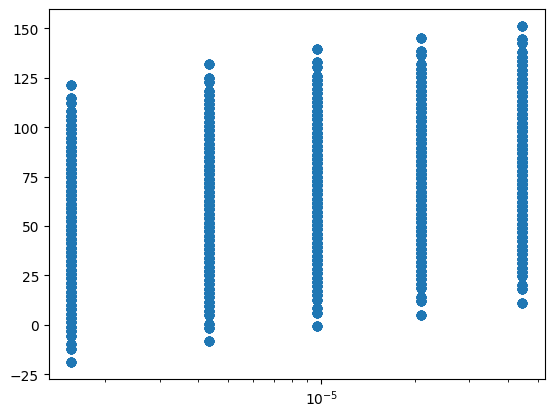

In [163]:
plt.scatter(WL_stage2_t, gain_stage2_t)
plt.xscale("log")

In [164]:
gain_stage2_OTA_mask = np.full(gain_stage2_t.flatten().shape, True)
for idx, gain in enumerate(gain_stage2_t.flatten()):
    if gain>74:
        gain_stage2_OTA_mask[idx] = True
    else:
        gain_stage2_OTA_mask[idx] = False

In [165]:
gma_1stage = np.repeat([i[1] for i in axes_2], 5)
Ra_1stage = np.repeat([i[0] for i in axes_2], 5)
Ca_1stage = np.repeat([i[2] for i in axes_2], 5)

gm_stage2 = np.asarray([i[3] for i in axes_2]).flatten()
Ro_stage2 = np.asarray([i[4] for i in axes_2]).flatten()

In [166]:
ro_stage2_OTA_mask = np.full(Ro_stage2_OTA.shape, True)
for idx, gain in enumerate(Ro_stage2_OTA):
    if gain>Ra_min:
        ro_stage2_OTA_mask[idx] = True
    else:
        ro_stage2_OTA_mask[idx] = False

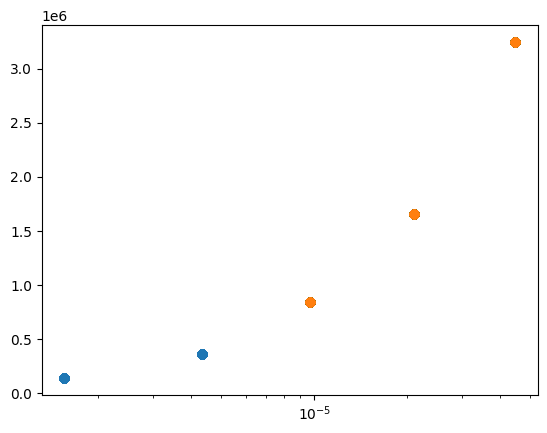

In [167]:
plt.scatter(WL_stage2_t.flatten(), Ro_stage2_OTA)
plt.scatter(WL_stage2_t.flatten()[ro_stage2_OTA_mask], Ro_stage2_OTA[ro_stage2_OTA_mask])
plt.xscale("log")

### GM

In [168]:
gm_stage2_OTA = np.abs(results_2[0].flatten())/Ro_stage2_OTA

gm_stage2_OTA_mask = np.full(gm_stage2_OTA.shape, True)
for idx, gain in enumerate(gm_stage2_OTA):
    if gain>gma_min:
        gm_stage2_OTA_mask[idx] = True
    else:
        gm_stage2_OTA_mask[idx] = False

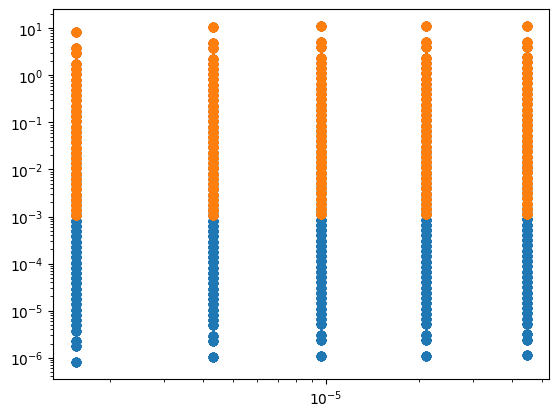

In [169]:
plt.scatter(WL_stage2_t.flatten(), gm_stage2_OTA)
plt.scatter(WL_stage2_t.flatten()[gm_stage2_OTA_mask], gm_stage2_OTA[gm_stage2_OTA_mask])
plt.xscale("log")
plt.yscale("log")

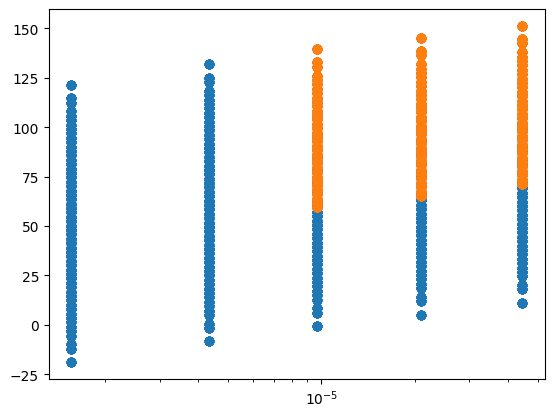

In [170]:
plt.scatter(WL_stage2_t, gain_stage2_t)
plt.scatter(WL_stage2_t.flatten()[gm_stage2_OTA_mask&ro_stage2_OTA_mask], gain_stage2_t.flatten()[gm_stage2_OTA_mask&ro_stage2_OTA_mask])
plt.xscale("log")

### Resume

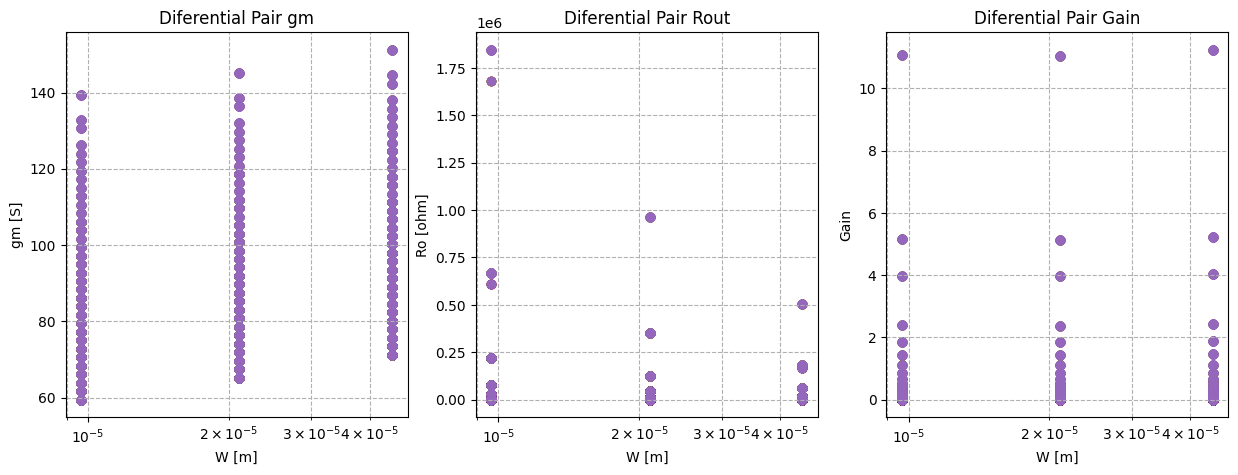

In [171]:
stage2_OTA_macro_mask = gm_stage2_OTA_mask&ro_stage2_OTA_mask

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for index, val in enumerate(lengths):
    axs[0].scatter(WL_stage2_t[stage2_OTA_macro_mask], gain_stage2_t.flatten()[stage2_OTA_macro_mask])

axs[0].set_title('Diferential Pair gm')
axs[0].set_xlabel('W [m]')
axs[0].set_ylabel('gm [S]')

for index, val in enumerate(lengths):
    axs[1].scatter(WL_stage2_t[stage2_OTA_macro_mask], gbw_final[stage2_OTA_macro_mask])

axs[1].set_title('Diferential Pair Rout')
axs[1].set_xlabel('W [m]')
axs[1].set_ylabel('Ro [ohm]')


for index, val in enumerate(lengths):
    axs[2].scatter(WL_stage2_t[stage2_OTA_macro_mask], gm_stage2_OTA[stage2_OTA_macro_mask])

axs[2].set_title('Diferential Pair Gain')
axs[2].set_xlabel('W [m]')
axs[2].set_ylabel('Gain')

axs[0].set_xscale('log')
axs[1].set_xscale('log')
axs[2].set_xscale('log')

axs[0].grid(linestyle = "dashed", which="both")
axs[1].grid(linestyle = "dashed", which="both")
axs[2].grid(linestyle = "dashed", which="both")

In [172]:
gma_1stage = np.repeat([i[1] for i in axes_2], 5)
Ra_1stage = np.repeat([i[0] for i in axes_2], 5)
Ca_1stage = np.repeat([i[2] for i in axes_2], 5)

gm_stage2 = np.asarray([i[3] for i in axes_2]).flatten()
Ro_stage2 = np.asarray([i[4] for i in axes_2]).flatten()

In [173]:
df_stage1 = pd.DataFrame({
    "gma": gma_1stage[stage2_OTA_macro_mask],
    "Ra": Ra_1stage[stage2_OTA_macro_mask],
    "Ca": Ca_1stage[stage2_OTA_macro_mask],
    "gain": 20*np.log10(gma_1stage[stage2_OTA_macro_mask]*Ra_1stage[stage2_OTA_macro_mask]),
})

df_stage1.sort_values(by=["gain"])

,gma,Ra,Ca,gain
95,0.000022,4.641589e+05,3.593814e-17,20.0
94,0.000022,4.641589e+05,3.593814e-17,20.0
93,0.000022,4.641589e+05,3.593814e-17,20.0
92,0.000022,4.641589e+05,1.000000e-17,20.0
102,0.000022,4.641589e+05,1.668101e-15,20.0
...,...,...,...,...
1875,0.010000,1.000000e+07,5.994843e-15,100.0
1884,0.010000,1.000000e+07,2.782559e-13,100.0
1876,0.010000,1.000000e+07,5.994843e-15,100.0
1882,0.010000,1.000000e+07,7.742637e-14,100.0


In [175]:
gma_1stage_min = 0.000022	
Ra_1stage_min = 4.641589e+05

gain_1stage_min = 20*np.log10(gma_1stage_min*Ra_1stage_min)
gain_1stage_min

np.float64(20.181787261140887)

In [238]:
print(gm_stage2_OTA[stage2_OTA_macro_mask].shape)
print(1/Ro_stage2_OTA[stage2_OTA_macro_mask])

(1890,)
[1.18042501e-06 6.04528659e-07 3.07913889e-07 ... 1.18042501e-06
 6.04528659e-07 3.07913889e-07]


In [177]:
np.tile(stage2_t.gm.flatten(), num_of_point_macro)[stage2_OTA_macro_mask]

array([0.0001109 , 0.00011038, 0.00011249, ..., 0.0001109 , 0.00011038,
       0.00011249])

In [178]:
print(W_stage2_t[stage2_OTA_macro_mask])
print(L_stage2_t[stage2_OTA_macro_mask])

[8.07143159e-06 1.78542805e-05 3.82212575e-05 ... 8.07143159e-06
 1.78542805e-05 3.82212575e-05]
[1.6e-06 3.2e-06 6.4e-06 ... 1.6e-06 3.2e-06 6.4e-06]


In [179]:
gain_stage2_t.flatten()[gm_stage2_OTA_mask&ro_stage2_OTA_mask]

array([ 61.68044902,  67.45191093,  73.47601229, ..., 139.4582268 ,
       145.22968871, 151.25379006])

## First stage OTA

In [180]:
OTA_macro.primitives = [diffpair_primitive, ota_cm_pmos]

#################### PSRR #######################
psrr = test()
psrr.tf = ("vout", "vpos")
psrr.parametros = {Symbol("gdif_2"): Symbol("gdif_1"),
                   Symbol("Rdif_2"): Symbol("Rdif_1"),
                   Symbol("V1"): 0,
                   Symbol("V_n"): 0,
                   Symbol("V_p"): 1,
                   Symbol("I2"): 0,
                   Symbol("s"): 0,
                   Symbol("Cl"): 1e-12}

psrr.conditions = {"min": [40]}
psrr.variables = {}
psrr.out_def = {"eval": psrr.tf}

#################### GBW #######################

gbw = test()
gbw.tf = ("vout", "vpos")
gbw.parametros = {Symbol("gdif_2"): Symbol("gdif_1"),
                   Symbol("Rdif_2"): Symbol("Rdif_1"),
                   Symbol("V1"): 0,
                   Symbol("V_n"): 0,
                   Symbol("V_p"): 1,
                   Symbol("I2"): 0,
                   Symbol("Cl"): 1e-12}
gbw.variables = {}
gbw.out_def = {"eval": gbw.tf}

OTA_macro.specifications = [psrr, gbw]

results_4, axes_4, primoutputs_4 = dfs(OTA_macro, levels=1)

Macro results of:  ota_cap
Running MNA... 
   net1  vs  vneg  vout  vpos  vss  vdd
0     1   2     3     4     5    0    6



   X server connection failed, although DISPLAY shell variable is set.
   A possible reason is that the X server is not running or DISPLAY shell variable
   is incorrectly set.
   Starting Xschem in text only mode.



[('vout', 'vpos'), ('vout', 'vpos')]
A:  Matrix([[1/Rdif_2 + 1/Raload_2, -gdif_2 - 1/Rdif_2, gdif_2, 0, 0, -1/Raload_2, 0, 0, 0], [-1/Rdif_2, Cgs*s + gdif_1 + gdif_2 + 1/Rdif_2 + 1/Rdif_1, -gdif_2, -1/Rdif_1, -Cgs*s - gdif_1, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 1, 0], [gaload, -gdif_1 - 1/Rdif_1, 0, Cgd*s + 1/Rdif_1 + 1/Raload_1, -Cgd*s + gdif_1, -gaload - 1/Raload_1, 0, 0, 0], [0, -Cgs*s, 0, -Cgd*s, Cgd*s + Cgs*s, 0, 0, 0, 1], [-gaload - 1/Raload_2, 0, 0, -1/Raload_1, 0, gaload + 1/Raload_2 + 1/Raload_1, 1, 0, 0], [0, 0, 0, 0, 0, 1, 0, 0, 0], [0, 0, 1, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 1, 0, 0, 0, 0]])
[v1, v2, v3, v4, v5, v6, I_V1, I_V_n, I_V_p]
{I_V1: (-Cgd*Cgs*Raload_1*Raload_2*Rdif_1*Rdif_2*V_n*gaload*gdif_2*s**2 + Cgd*Cgs*Raload_1*Raload_2*Rdif_1*Rdif_2*V_p*gaload*gdif_2*s**2 - Cgd*Cgs*Raload_1*Raload_2*Rdif_1*V1*gaload*s**2 + Cgd*Cgs*Raload_1*Raload_2*Rdif_1*V_p*gaload*s**2 - Cgd*Cgs*Raload_1*Rdif_1*Rdif_2*V_n*gdif_2*s**2 + Cgd*Cgs*Raload_1*Rdif_1*Rdif_2*V_p*gdif_2*s**2 - Cgd*Cgs*R

In [181]:
OTA_macro.name = "OTA_cap_r"

#################### rout #######################
rout = test()
rout.tf = ["vout", "vr"]
rout.parametros = {Symbol("gdif_2"): Symbol("gdif_1"),
                   Symbol("Rdif_2"): Symbol("Rdif_1"),
                   Symbol("V1"): 0,
                   Symbol("V_n"): 0,
                   Symbol("V_p"): 0,
                   Symbol("Vr"): 1,
                   Symbol("I2"): 0,
                   Symbol("s"): 0,
                   Symbol("Rr"): 1000,
                   Symbol("Cl"): 1e-12}
rout.variables = {}
rout.out_def = {"eval": rout.tf}

OTA_macro.specifications = [rout]

results_5, axes_5, primoutputs_5 = dfs(OTA_macro, levels=1)

Macro results of:  OTA_cap_r
Running MNA... 
   net1  vs  vneg  vout  vpos  vss  vdd  vr
0     1   2     3     4     5    0    6   7



   X server connection failed, although DISPLAY shell variable is set.
   A possible reason is that the X server is not running or DISPLAY shell variable
   is incorrectly set.
   Starting Xschem in text only mode.



[['vout', 'vr']]
A:  Matrix([[1/Rdif_2 + 1/Raload_2, -gdif_2 - 1/Rdif_2, gdif_2, 0, 0, -1/Raload_2, 0, 0, 0, 0, 0], [-1/Rdif_2, Cgs*s + gdif_1 + gdif_2 + 1/Rdif_2 + 1/Rdif_1, -gdif_2, -1/Rdif_1, -Cgs*s - gdif_1, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0], [gaload, -gdif_1 - 1/Rdif_1, 0, Cgd*s + 1/Rr + 1/Rdif_1 + 1/Raload_1, -Cgd*s + gdif_1, -gaload - 1/Raload_1, -1/Rr, 0, 0, 0, 0], [0, -Cgs*s, 0, -Cgd*s, Cgd*s + Cgs*s, 0, 0, 0, 0, 1, 0], [-gaload - 1/Raload_2, 0, 0, -1/Raload_1, 0, gaload + 1/Raload_2 + 1/Raload_1, 0, 1, 0, 0, 0], [0, 0, 0, -1/Rr, 0, 0, 1/Rr, 0, 0, 0, 1], [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]])
[v1, v2, v3, v4, v5, v6, v7, I_V1, I_V_n, I_V_p, I_Vr]
{I_V1: (-Cgd*Cgs*Raload_1*Raload_2*Rdif_1*Rdif_2*Rr*V_n*gaload*gdif_2*s**2 + Cgd*Cgs*Raload_1*Raload_2*Rdif_1*Rdif_2*Rr*V_p*gaload*gdif_2*s**2 - Cgd*Cgs*Raload_1*Raload_2*Rdif_1*Rr*V1*gaload*s**2 + Cgd*Cgs*Raload_1*

In [182]:
W_diff = np.tile(diffpair_primitive.W.flatten(), 5).reshape(5, 100)
L_diff = np.tile(diffpair_primitive.L.flatten(), 5).reshape(5, 100)
WL_diff =W_diff+L_diff

W_al = np.repeat(ota_cm_pmos.W.flatten(), 100).reshape(5, 100)
L_al = np.repeat(ota_cm_pmos.L.flatten(), 100).reshape(5, 100)
WL_al = W_al+L_al

area_1stage = WL_diff+WL_al
gain_1stage = 20*np.log10(np.abs(results_4[0].reshape(5, 100)))

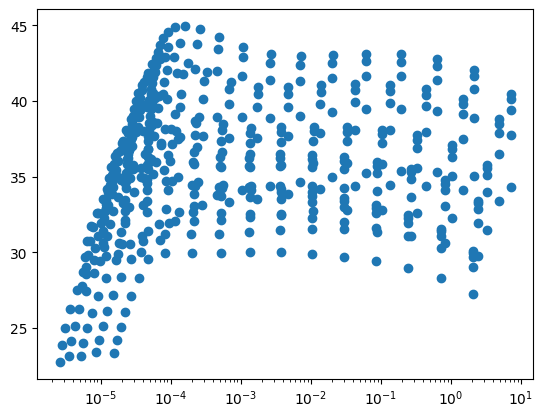

In [183]:
plt.scatter(area_1stage.flatten(), gain_1stage.flatten())
plt.xscale("log")

In [184]:
Ro_stage1_OTA = results_5[0].flatten()*1000/(1-results_5[0].flatten())
Ro_stage1_OTA

array([ 110466.61888575,  108061.6213594 ,  105260.52084895,
        101927.70774125,   97892.67052473,   93014.00539047,
         87310.18072014,   81174.33508283,   75396.42833159,
         70772.26505554,   67504.64537404,   65264.77304252,
         63545.50584381,   61980.33821905,   60364.59293393,
         58545.02919778,   56387.91767915,   53702.35390692,
         50154.36697424,   45083.65582319,  124191.11796057,
        122173.80566795,  119790.7778029 ,  116918.42296016,
        113387.3744825 ,  108998.09127104,  103575.36551741,
         97138.39221369,   90138.78556868,   83559.65696426,
         78368.31804461,   74885.09828668,   72668.07899568,
         71110.59124183,   69768.25060187,   68351.2168552 ,
         66650.32916551,   64399.24275892,   61106.30222038,
         55694.75154457,  131585.21823586,  129970.66993909,
        128058.67223892,  125752.12343778,  122912.86834558,
        119358.66665234,  114869.35550801,  109261.0991003 ,
        102565.41955469,

In [185]:
ro_stage1_OTA_mask = np.full(Ro_stage1_OTA.shape, True)
for idx, gain in enumerate(Ro_stage1_OTA):
    if gain>Ra_1stage_min:
        ro_stage1_OTA_mask[idx] = True
    else:
        ro_stage1_OTA_mask[idx] = False

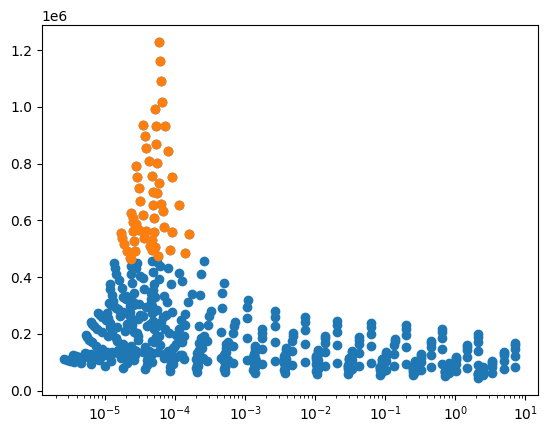

In [186]:
plt.scatter(area_1stage.flatten(), Ro_stage1_OTA)
plt.scatter(area_1stage.flatten()[ro_stage1_OTA_mask], Ro_stage1_OTA[ro_stage1_OTA_mask])
plt.xscale("log")

In [187]:
gm_stage1_OTA = np.abs(results_4[0].flatten())/Ro_stage1_OTA

gm_stage1_OTA_mask = np.full(gm_stage1_OTA.shape, True)
for idx, gain in enumerate(gm_stage1_OTA):
    if gain>gma_1stage_min:
        gm_stage1_OTA_mask[idx] = True
    else:
        gm_stage1_OTA_mask[idx] = False

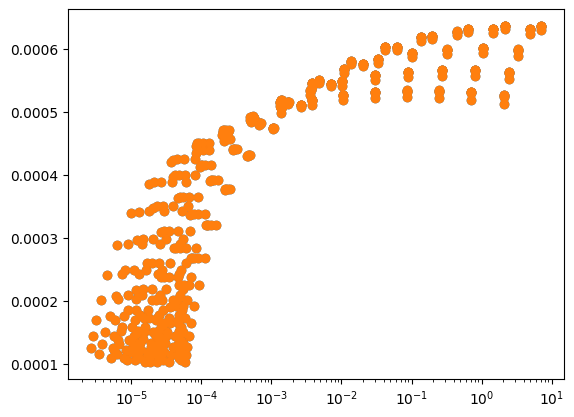

In [188]:
plt.scatter(area_1stage.flatten(), gm_stage1_OTA)
plt.scatter(area_1stage.flatten()[gm_stage1_OTA_mask], gm_stage1_OTA[gm_stage1_OTA_mask])
plt.xscale("log")

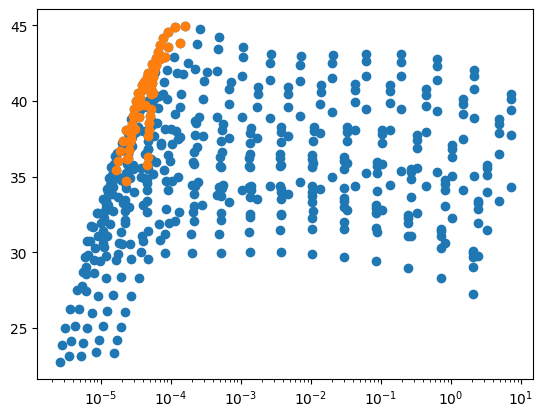

In [189]:
stage1_OTA_macro_mask = gm_stage1_OTA_mask&ro_stage1_OTA_mask

plt.scatter(area_1stage.flatten(), gain_1stage.flatten())
plt.scatter(area_1stage.flatten()[stage1_OTA_macro_mask], gain_1stage.flatten()[stage1_OTA_macro_mask])
plt.xscale("log")

In [72]:
gain_1stage.flatten()[stage1_OTA_macro_mask].shape

(10,)

In [190]:
print(W_diff.flatten()[stage1_OTA_macro_mask])
print(L_diff.flatten()[stage1_OTA_macro_mask])
print(W_al.flatten()[stage1_OTA_macro_mask])
print(L_al.flatten()[stage1_OTA_macro_mask])

[3.83549017e-06 4.72375359e-06 5.95748419e-06 7.73926030e-06
 1.04362366e-05 7.50704243e-06 9.17573862e-06 1.14663882e-05
 1.47276581e-05 1.95790317e-05 2.71981489e-05 3.99815192e-05
 1.18560465e-06 2.06378434e-06 2.56151256e-06 3.26667229e-06
 4.31082822e-06 3.83549017e-06 4.72375359e-06 5.95748419e-06
 7.73926030e-06 1.04362366e-05 1.47616142e-05 2.22003070e-05
 7.50704243e-06 9.17573862e-06 1.14663882e-05 1.47276581e-05
 1.95790317e-05 2.71981489e-05 3.99815192e-05 6.31784038e-05
 1.09202552e-04 1.18560465e-06 1.49525906e-06 2.06378434e-06
 2.56151256e-06 3.26667229e-06 4.31082822e-06 5.94140697e-06
 3.83549017e-06 4.72375359e-06 5.95748419e-06 7.73926030e-06
 1.04362366e-05 1.47616142e-05 2.22003070e-05 3.60779163e-05
 7.50704243e-06 9.17573862e-06 1.14663882e-05 1.47276581e-05
 1.95790317e-05 2.71981489e-05 3.99815192e-05 6.31784038e-05
 1.09202552e-04]
[3.2e-06 3.2e-06 3.2e-06 3.2e-06 3.2e-06 6.4e-06 6.4e-06 6.4e-06 6.4e-06
 6.4e-06 6.4e-06 6.4e-06 8.0e-07 1.6e-06 1.6e-06 1.6e-06

In [197]:
Ro_stage1_OTA[ro_stage1_OTA_mask]

array([ 557147.37943155,  538225.57220448,  516871.79042731,
        492610.39057711,  464881.53902845,  625306.50394544,
        607774.49228763,  587874.10627002,  565097.83275184,
        538811.07485504,  508272.96299436,  472710.80563268,
        467704.69597221,  593983.18946175,  562324.15942767,
        528063.58231772,  490766.57741757,  791794.34173549,
        754118.12407532,  712855.69124057,  667516.09940195,
        617600.27429064,  562743.84889188,  502979.06692141,
        936928.34815338,  898111.2112017 ,  855326.68992773,
        807948.42222969,  755268.01150281,  696602.76720876,
        631494.77059689,  560307.4975485 ,  485092.4470345 ,
        530566.75499017,  495414.3486818 ,  699243.39966377,
        655771.6201988 ,  609635.40047316,  560450.96844125,
        507871.93668242,  990634.88167056,  932348.7877659 ,
        870074.1667255 ,  803454.7417245 ,  732211.45841436,
        656342.58185405,  576438.4657974 ,  494364.98123516,
       1228810.13320145,

In [191]:
diffpair_primitive.W.shape

np.tile(np.tile(vs, 5), 5)[stage1_OTA_macro_mask]

array([0.1       , 0.13684211, 0.17368421, 0.21052632, 0.24736842,
       0.1       , 0.13684211, 0.17368421, 0.21052632, 0.24736842,
       0.28421053, 0.32105263, 0.1       , 0.1       , 0.13684211,
       0.17368421, 0.21052632, 0.1       , 0.13684211, 0.17368421,
       0.21052632, 0.24736842, 0.28421053, 0.32105263, 0.1       ,
       0.13684211, 0.17368421, 0.21052632, 0.24736842, 0.28421053,
       0.32105263, 0.35789474, 0.39473684, 0.1       , 0.13684211,
       0.1       , 0.13684211, 0.17368421, 0.21052632, 0.24736842,
       0.1       , 0.13684211, 0.17368421, 0.21052632, 0.24736842,
       0.28421053, 0.32105263, 0.35789474, 0.1       , 0.13684211,
       0.17368421, 0.21052632, 0.24736842, 0.28421053, 0.32105263,
       0.35789474, 0.39473684])

# FINAL RUN

In [241]:
print(Ro_stage1_OTA[stage1_OTA_macro_mask])
print(gm_stage1_OTA[stage1_OTA_macro_mask])

print(Ro_stage2[stage2_OTA_macro_mask])
print(gm_stage2[stage2_OTA_macro_mask].shape)

[ 557147.37943155  538225.57220448  516871.79042731  492610.39057711
  464881.53902845  625306.50394544  607774.49228763  587874.10627002
  565097.83275184  538811.07485504  508272.96299436  472710.80563268
  467704.69597221  593983.18946175  562324.15942767  528063.58231772
  490766.57741757  791794.34173549  754118.12407532  712855.69124057
  667516.09940195  617600.27429064  562743.84889188  502979.06692141
  936928.34815338  898111.2112017   855326.68992773  807948.42222969
  755268.01150281  696602.76720876  631494.77059689  560307.4975485
  485092.4470345   530566.75499017  495414.3486818   699243.39966377
  655771.6201988   609635.40047316  560450.96844125  507871.93668242
  990634.88167056  932348.7877659   870074.1667255   803454.7417245
  732211.45841436  656342.58185405  576438.4657974   494364.98123516
 1228810.13320145 1162885.02498435 1092141.56370722 1016054.61617862
  934107.31744421  845979.148816    751826.99191828  653030.05133033
  553061.31562945]
[0.00010635 0.000

In [222]:
## Electrical variables

Vg_ota = np.linspace(LDO_macro.electrical_parameters["Vdd"] - (LDO_macro.electrical_parameters["Vdd"] - LDO_macro.electrical_parameters["Vaout"]), LDO_macro.electrical_parameters["Vdd"], 5)

final_stage1_primitive = Primitive(parameters={Symbol('Ra_1stage'): Ro_stage1_OTA[stage1_OTA_macro_mask],
                                               Symbol("gma_1stage"): gm_stage1_OTA[stage1_OTA_macro_mask]})

final_stage2_primitive = Primitive(parameters={Symbol('Ro_stage2'): Ro_stage2[stage2_OTA_macro_mask],
                                               Symbol("gm_stage2"): gm_stage2[stage2_OTA_macro_mask]})

stage2_OTA_macro = Macromodel(name = "stage2_OTA", 
                       req_tfs = [["vout", "V_p"], ["vout", "V_p"]], 
                       primitives = [final_stage2_primitive, final_stage1_primitive])

#################### PSRR #######################
psrr = test()
psrr.tf = ["vout", "V_p"]
psrr.parametros = {Symbol("V1"): 0,
                   Symbol("V2"): 1,
                   Symbol("V3"): 0,
                   Symbol("Il"): 0, 
                   Symbol("I2"): 0,
                   Symbol("Cl"): 0,
                   Symbol("s"): 0}
psrr.variables = {}
psrr.out_def = {"eval": psrr.tf}
 
#################### PSRR #######################
gbw = test()
gbw.tf = ["vout", "V_p"]
gbw.parametros = { Symbol("V1"): 0,
                   Symbol("V2"): 1,
                   Symbol("V3"): 0,
                   Symbol("Il"): 0,
                   Symbol("I2"): 0,
                   Symbol("Cl"): 1e-12}
gbw.variables = {}
gbw.out_def = {"eval": gbw.tf}

stage2_OTA_macro.specifications = [psrr, gbw]
results_stage2, axes_stage2, primoutputs_stage2 = dfs(stage2_OTA_macro, levels=1)

Macro results of:  stage2_OTA
Running MNA... 
   net1  vout  Vaout  vss  V_p  V_n
0     1     2      3    0    4    5
[['vout', 'V_p'], ['vout', 'V_p']]
A:  Matrix([[gm_stage2 + 1/Ro_stage2, -1/Ro_stage2, -gm_stage2, 0, 0, 1, 0, 0], [-gm_stage2 - 1/Ro_stage2, C2*s + Cl*s + 1/Ro_stage2, -C2*s + gm_stage2, 0, 0, 0, 0, 0], [0, -C2*s, C2*s + Ca_1stage*s + 1/Ra_1stage, -gma_1stage, gma_1stage, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 1], [0, 0, 0, 0, 0, 0, 1, 0], [1, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 1, 0, 0, 0], [0, 0, 0, 1, 0, 0, 0, 0]])
[v1, v2, v3, v4, v5, I_V1, I_V3, I_V2]
{I_V1: (-C2*Ca_1stage*Ra_1stage*Ro_stage2*V1*gm_stage2*s**2 - C2*Ca_1stage*Ra_1stage*V1*s**2 - C2*Cl*Ra_1stage*Ro_stage2*V1*gm_stage2*s**2 - C2*Cl*Ra_1stage*V1*s**2 - C2*I2*Ra_1stage*Ro_stage2*gm_stage2*s - C2*I2*Ra_1stage*s + C2*Ra_1stage*Ro_stage2*V2*gm_stage2*gma_1stage*s - C2*Ra_1stage*Ro_stage2*V3*gm_stage2*gma_1stage*s + C2*Ra_1stage*V2*gma_1stage*s - C2*Ra_1stage*V3*gma_1stage*s - C2*Ro_stage2*V1*gm_stage2*s - C2*V1*s


   X server connection failed, although DISPLAY shell variable is set.
   A possible reason is that the X server is not running or DISPLAY shell variable
   is incorrectly set.
   Starting Xschem in text only mode.



in eval


In [243]:
stage2_OTA_macro.name = "stage2_OTA_r"

stage2_OTA_macro.primitives = [final_stage2_primitive, final_stage1_primitive]

#################### rout #######################
rout = test()
rout.tf = ["vout", "vr"]
rout.parametros = {Symbol("V1"): 0,
                   Symbol("V2"): 0,
                   Symbol("V3"): 0,
                   Symbol("V4"): 1,
                   Symbol("Ra_1"): 1000,
                   Symbol("I2"): 0,
                   Symbol("Cl"): 0,
                   Symbol("s"): 0}
rout.variables = {}
rout.out_def = {"eval": rout.tf}

stage2_OTA_macro.specifications = [rout]

results_3, axes_3, primoutputs_3 = dfs(stage2_OTA_macro, levels=1)

Macro results of:  stage2_OTA_r
Running MNA... 
   net1  vout  Vaout  vss  V_p  V_n  vr
0     1     2      3    0    4    5   6



   X server connection failed, although DISPLAY shell variable is set.
   A possible reason is that the X server is not running or DISPLAY shell variable
   is incorrectly set.
   Starting Xschem in text only mode.



[['vout', 'vr']]
A:  Matrix([[gm_stage2 + 1/Ro_stage2, -1/Ro_stage2, -gm_stage2, 0, 0, 0, 1, 0, 0, 0], [-gm_stage2 - 1/Ro_stage2, C2*s + Cl*s + 1/Ro_stage2 + 1/Ra_1, -C2*s + gm_stage2, 0, 0, -1/Ra_1, 0, 0, 0, 0], [0, -C2*s, C2*s + Ca_1stage*s + 1/Ra_1stage, -gma_1stage, gma_1stage, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 1, 0], [0, 0, 0, 0, 0, 0, 0, 1, 0, 0], [0, -1/Ra_1, 0, 0, 0, 1/Ra_1, 0, 0, 0, 1], [1, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 1, 0, 0, 0, 0]])
[v1, v2, v3, v4, v5, v6, I_V1, I_V3, I_V2, I_V4]
{I_V1: (-C2*Ca_1stage*Ra_1*Ra_1stage*Ro_stage2*V1*gm_stage2*s**2 - C2*Ca_1stage*Ra_1*Ra_1stage*V1*s**2 - C2*Cl*Ra_1*Ra_1stage*Ro_stage2*V1*gm_stage2*s**2 - C2*Cl*Ra_1*Ra_1stage*V1*s**2 - C2*I2*Ra_1*Ra_1stage*Ro_stage2*gm_stage2*s - C2*I2*Ra_1*Ra_1stage*s + C2*Ra_1*Ra_1stage*Ro_stage2*V2*gm_stage2*gma_1stage*s - C2*Ra_1*Ra_1stage*Ro_stage2*V3*gm_stage2*gma_1stage*s + C2*Ra_1*Ra_1stage*V2*gma_1stage*s - C2*Ra_1*Ra_

In [244]:
Ro_stage2_OTA = results_3[0].flatten()*1000/(1-results_3[0].flatten())
Ro_stage2_OTA

array([ 847152.4981871 , 1654181.29428832, 3247661.22929465, ...,
        847152.4981871 , 1654181.29428832, 3247661.22929465])

In [246]:
gm_stage2_OTA = np.abs(results_stage2[0].flatten())/Ro_stage2_OTA
gm_stage2_OTA.shape

(107730,)

In [264]:
gm_stage2_OTA.shape

(107730,)

In [265]:
final_OTA = Primitive(parameters={Symbol("Ra"): Ro_stage2_OTA,
                                  Symbol("gma"): gm_stage2_OTA,
                                  Symbol('Ca'): np.logspace(-17, -12, 107730)})

pt_final = Primitive(parameters={Symbol('gm_pt'): gm_pt[ldo_macro_mask],
                                Symbol('Ro_pt'): Ro_pt[ldo_macro_mask]})

In [267]:
LDO_macro.primitives = [pt_final, final_OTA]
LDO_macro.submacromodels = []

#################### PSRR #######################
psrr = test()
psrr.tf = ["vout", "vdd"]
psrr.parametros = {Symbol("V1"): 1,
                   Symbol("V2"): 0,
                   Symbol("s"): 0,
                   Symbol("Rl"): RL,
                   Symbol("Cl"): CL,
                   Symbol("Cc"): 1e-12,
                   Symbol("R1"): 100000,
                   Symbol("R2"): 300000}

psrr.conditions = {"max": [-70]}
psrr.variables = {}
psrr.out_def = {"eval": psrr.tf}

#################### gbw #######################
gbw = test()
gbw.tf = ["vout", "vdd"]
gbw.parametros = {Symbol("V1"): 1,
                  Symbol("V2"): 0,
                  Symbol("Rl"): RL,
                  Symbol("Cl"): CL,
                   Symbol("Cc"): 1e-12,
                  Symbol("R1"): 100000,
                  Symbol("R2"): 300000}
gbw.conditions = {"min": [1e4]}
gbw.variables = {}
gbw.out_def = {"eval": gbw.tf}

#################### load regulation #######################
loadreg = test()
loadreg.tf = ["vout", "vdd"]
loadreg.parametros = {Symbol("V1"): 1.8,
                      Symbol("V2"): 0.9,
                      Symbol("s"): 0,
                      Symbol("Cl"): CL,
                      Symbol("Cc"): 1e-12,
                      Symbol("R1"): 100000,
                      Symbol("R2"): 300000}
loadreg.variables = {Symbol('Rl'): [RL, RL+1200]}
loadreg.out_def = {'diff': [loadreg.tf, loadreg.variables]}
loadreg.conditions = {'max': [1]}

LDO_macro.specifications = [psrr, loadreg]

results, axes, primoutputs = dfs(LDO_macro, levels = 1)

Macro results of:  ldo
Running MNA... 



   X server connection failed, although DISPLAY shell variable is set.
   A possible reason is that the X server is not running or DISPLAY shell variable
   is incorrectly set.
   Starting Xschem in text only mode.



   vdd  vout  net1  vfb  vss  net2
0    1     2     3    4    0     5
[['vout', 'vdd'], ['vout', 'vdd']]
A:  Matrix([[Ca*s + gm_pt + 1/Ro_pt + 1/Ra, -1/Ro_pt, -Ca*s - gm_pt - 1/Ra, gma, -gma, 1, 0], [-gm_pt - 1/Ro_pt, Cc*s + Cl*s + 1/Ro_pt + 1/Rl + 1/R1, -Cc*s + gm_pt, -1/R1, 0, 0, 0], [-Ca*s - 1/Ra, -Cc*s, Ca*s + Cc*s + 1/Ra, -gma, gma, 0, 0], [0, -1/R1, 0, 1/R2 + 1/R1, 0, 0, 0], [0, 0, 0, 0, 0, 0, 1], [1, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 1, 0, 0]])
[v1, v2, v3, v4, v5, I_V1, I_V2]
{I_V1: (-Ca*Cc*Cl*R1*Ra*Rl*Ro_pt*V1*s**3 - Ca*Cc*Cl*R2*Ra*Rl*Ro_pt*V1*s**3 - Ca*Cc*R1*Ra*Ro_pt*V1*s**2 - Ca*Cc*R2*Ra*Ro_pt*V1*s**2 - Ca*Cc*Ra*Rl*Ro_pt*V1*s**2 - Ca*Cl*R1*Ra*Rl*V1*s**2 - Ca*Cl*R2*Ra*Rl*V1*s**2 - Ca*R1*Ra*V1*s - Ca*R2*Ra*V1*s - Ca*Ra*Rl*V1*s - Cc*Cl*R1*Ra*Rl*Ro_pt*V1*gm_pt*s**2 + Cc*Cl*R1*Ra*Rl*Ro_pt*V2*gma*s**2 - Cc*Cl*R1*Ra*Rl*V1*s**2 - Cc*Cl*R1*Rl*Ro_pt*V1*s**2 - Cc*Cl*R2*Ra*Rl*Ro_pt*V1*gm_pt*s**2 + Cc*Cl*R2*Ra*Rl*Ro_pt*V2*gma*s**2 - Cc*Cl*R2*Ra*Rl*V1*s**2 - Cc*Cl*R2*Rl*Ro_pt*V1*s**2 - Cc*R

In [282]:
20*np.log10(np.abs(results[0].flatten())).shape

(12388950,
 12388950,
 12388950,
 12388950,
 12388950,
 12388950,
 12388950,
 12388950,
 12388950,
 12388950,
 12388950,
 12388950,
 12388950,
 12388950,
 12388950,
 12388950,
 12388950,
 12388950,
 12388950,
 12388950)

In [294]:
20*np.log10(np.abs(results[0].flatten()))[5000]

np.float64(-99.09028430511158)

: 